# Load Train Data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [5]:
def load_file(
    path="", 
    usecols=None
):
    # LOAD DATAFRAME
    if usecols is not None: 
        df = pd.read_parquet(path, columns=usecols)
    else: 
        df = pd.read_parquet(path)
    
    # REDUCE DTYPE FOR CUSTOMER AND DATE
    df["customer_ID"] = df["customer_ID"].str[-16:]
    
    hex_to_int = lambda x: int(x, 16)
    df[["customer_ID"]] = df[["customer_ID"]].applymap(lambda x: int(x, 16))
    
    df["customer_ID"] = df["customer_ID"].astype("int64")
    df["S_2"] = pd.to_datetime(df["S_2"])
    
    # SORT BY CUSTOMER AND DATE (so agg("last") works correctly)
    df = df.sort_values(["customer_ID", "S_2"])
    df = df.reset_index(drop=True)
    
    # FILL NAN
    print("shape of data:", df.shape)
    
    return df

def add_target(df):
    
    targets = pd.read_csv("../input/train_labels.csv")
    
    # REDUCE DTYPE FOR CUSTOMER AND DATE
    targets["customer_ID"] = targets["customer_ID"].str[-16:]
    
    hex_to_int = lambda x: int(x, 16)
    targets[["customer_ID"]] = targets[["customer_ID"]].applymap(lambda x: int(x, 16))
    targets["customer_ID"] = targets["customer_ID"].astype("int64")
    
    df = df.merge(targets, on="customer_ID", how="left")
    df.target = df.target.astype("int8")

    # NEEDED TO MAKE CV DETERMINISTIC (cudf merge above randomly shuffles rows)
    df = df.sort_index().reset_index()
    
    return df

In [6]:
TRAIN_PATH = "../input/amex-data-integer-dtypes-parquet-format/train.parquet"
train = load_file(path = TRAIN_PATH)

shape of data: (5531451, 190)


In [7]:
train = add_target(train)

In [9]:
def plot_time_series(prefix="D", cols=None, display_ct=32):
    
    # DETERMINE WHICH COLUMNS TO PLOT
    if cols is not None and len(cols)==0: cols = None
    if cols is None:
        COLS = train.columns[2:-1]
        COLS = np.sort( [int(x[2:]) for x in COLS if x[0]==prefix] )
        COLS = [f"{prefix}_{x}" for x in COLS]
        print("#"*25)
        print(f"Plotting all {len(COLS)} columns with prefix {prefix}")
        print("#"*25)
    else:
        COLS = [f"{prefix}_{x}" for x in cols]
        print("#"*25)
        print(f"Plotting {len(COLS)} columns with prefix {prefix}")
        print("#"*25)

    # ITERATE COLUMNS
    for c in COLS:

        # CONVERT DATAFRAME INTO SERIES WITH COLUMN
        tmp = train[["customer_ID","S_2",c,"target"]].copy()
        tmp2 = tmp.groupby(["customer_ID","target"])[["S_2",c]].agg(list).reset_index()
        tmp3 = tmp2.loc[tmp2.target==1]
        tmp4 = tmp2.loc[tmp2.target==0]

        # FORMAT PLOT
        spec = gridspec.GridSpec(ncols=2, nrows=1,
                             width_ratios=[3, 1], wspace=0.1,
                             hspace=0.5, height_ratios=[1])
        fig = plt.figure(figsize=(20,10))
        ax0 = fig.add_subplot(spec[0])

        # PLOT 32 DEFAULT CUSTOMERS AND 32 NON-DEFAULT CUSTOMERS
        t0 = []; t1 = []
        for k in range(display_ct):
            try:
                # PLOT DEFAULTING CUSTOMERS
                row = tmp3.iloc[k]
                ax0.plot(row.S_2,row[c],"-o",color="blue")
                t1 += row[c]
                # PLOT NON-DEFAULT CUSTOMERS
                row = tmp4.iloc[k]
                ax0.plot(row.S_2,row[c],"-o",color="orange")
                t0 += row[c]
            except:
                pass
        plt.title(f"Feature {c} (Key: BLUE=DEFAULT, orange=no default)",size=18)

        # PLOT HISTOGRAMS
        ax1 = fig.add_subplot(spec[1])
        try:
            # COMPUTE BINS
            t = t0+t1; mn = np.nanmin(t); mx = np.nanmax(t)
            if mx==mn:
                mx += 0.01; mn -= 0.01
            bins = np.arange(mn,mx+(mx-mn)/20,(mx-mn)/20 )
            # PLOT HISTOGRAMS
            if np.sum(np.isnan(t1))!=len(t1):
                ax1.hist(t1,bins=bins,orientation="horizontal",alpha = 0.8,color="blue")
            if np.sum(np.isnan(t0))!=len(t0):
                ax1.hist(t0,bins=bins,orientation="horizontal",alpha = 0.8,color="orange")
        except:
            pass
        plt.show()

# Plot Delinquency Variables

#########################
Plotting 15 columns with prefix D
#########################


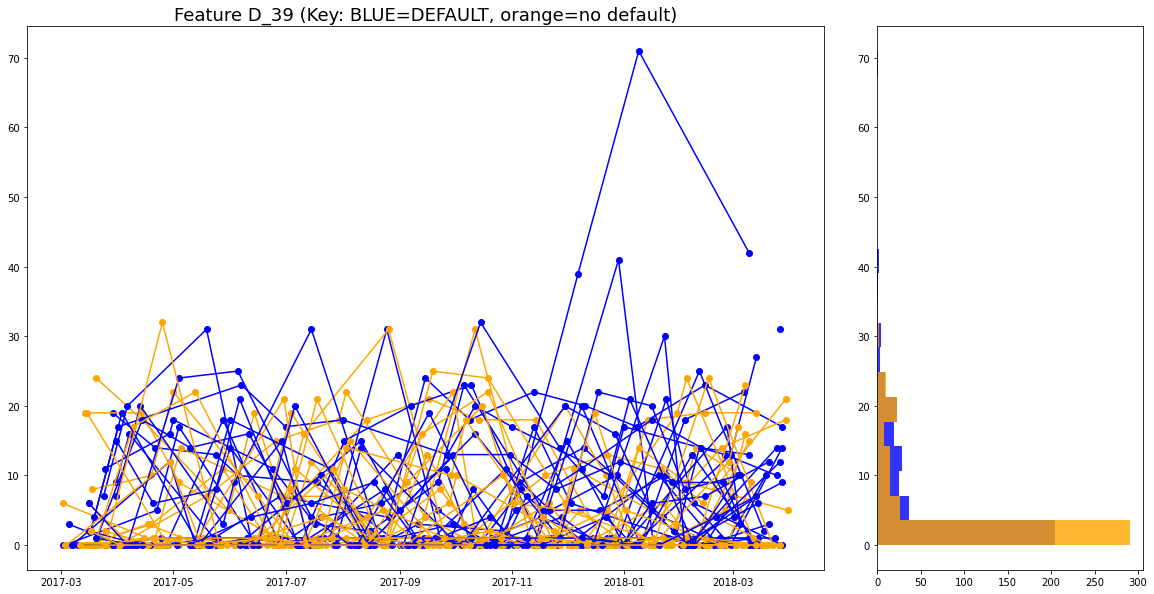

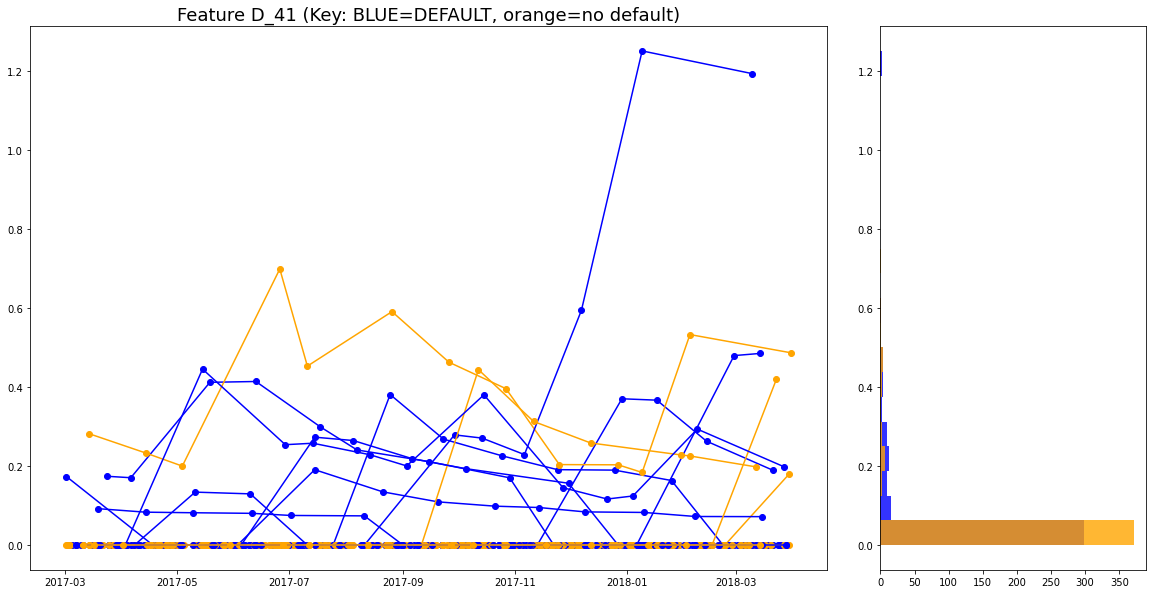

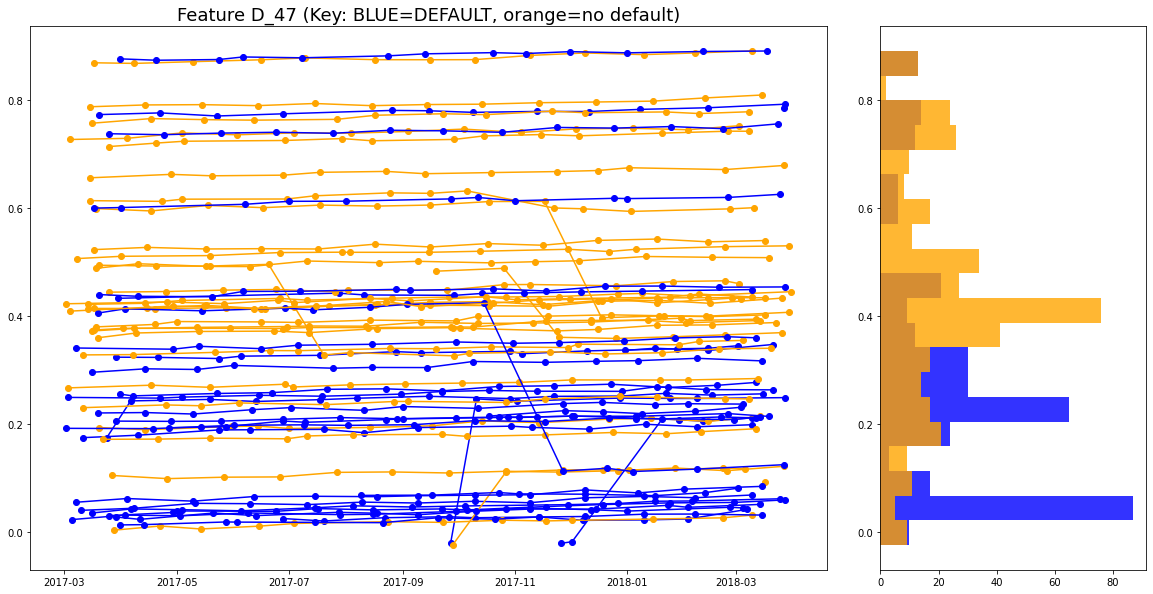

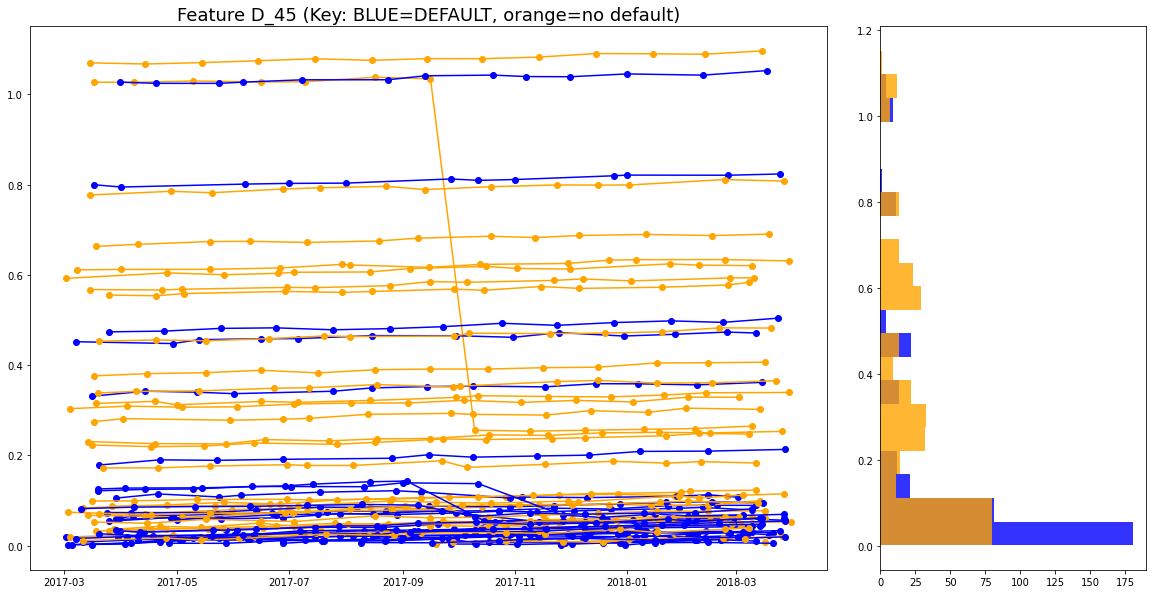

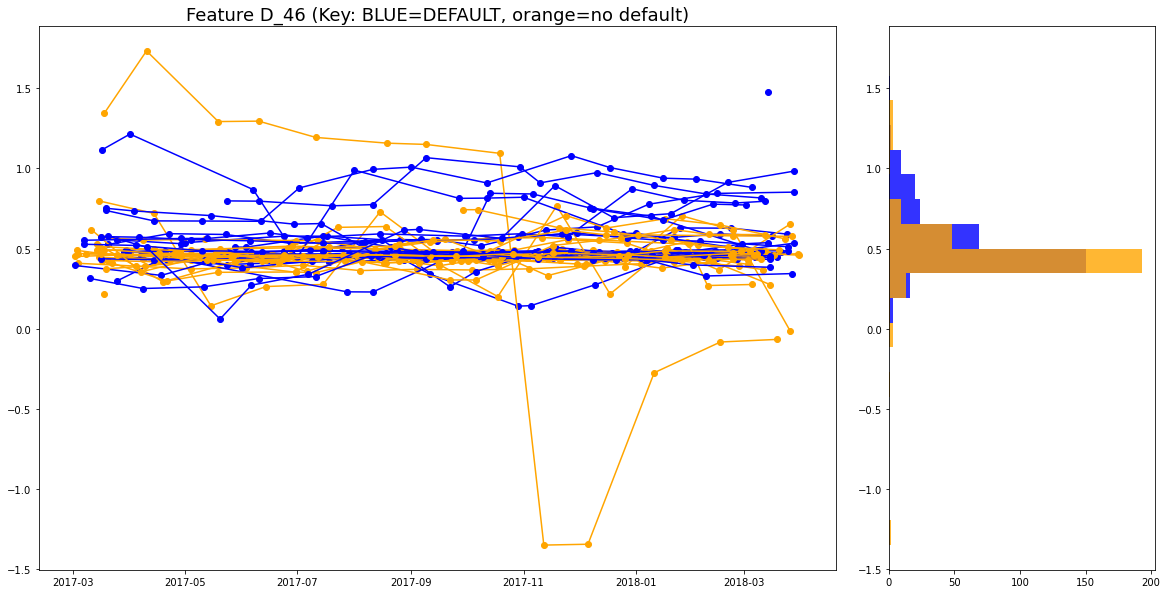

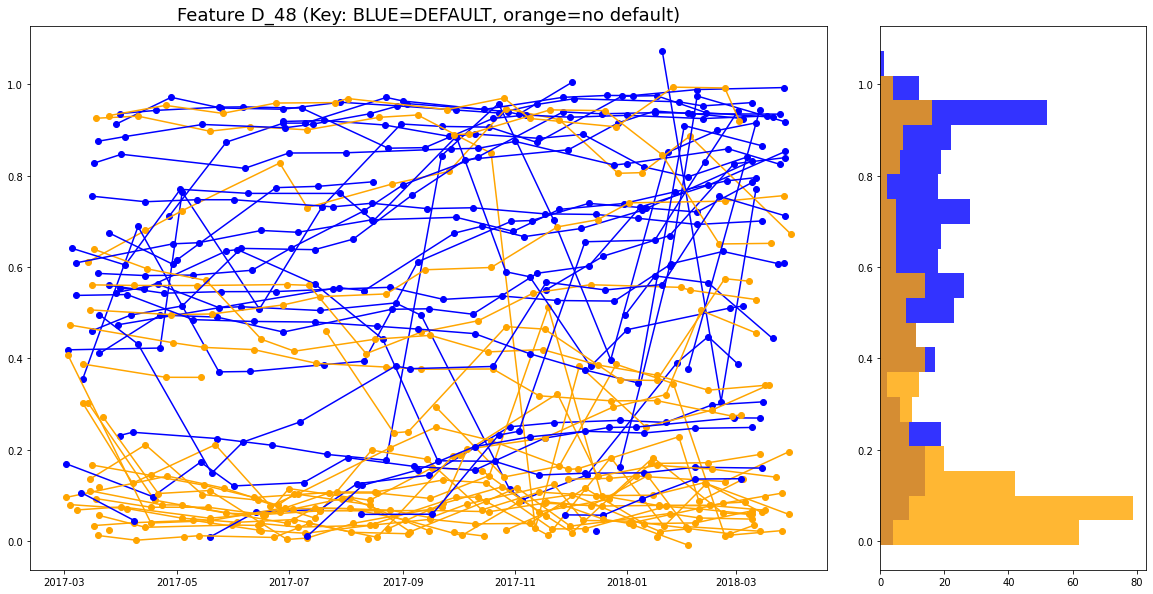

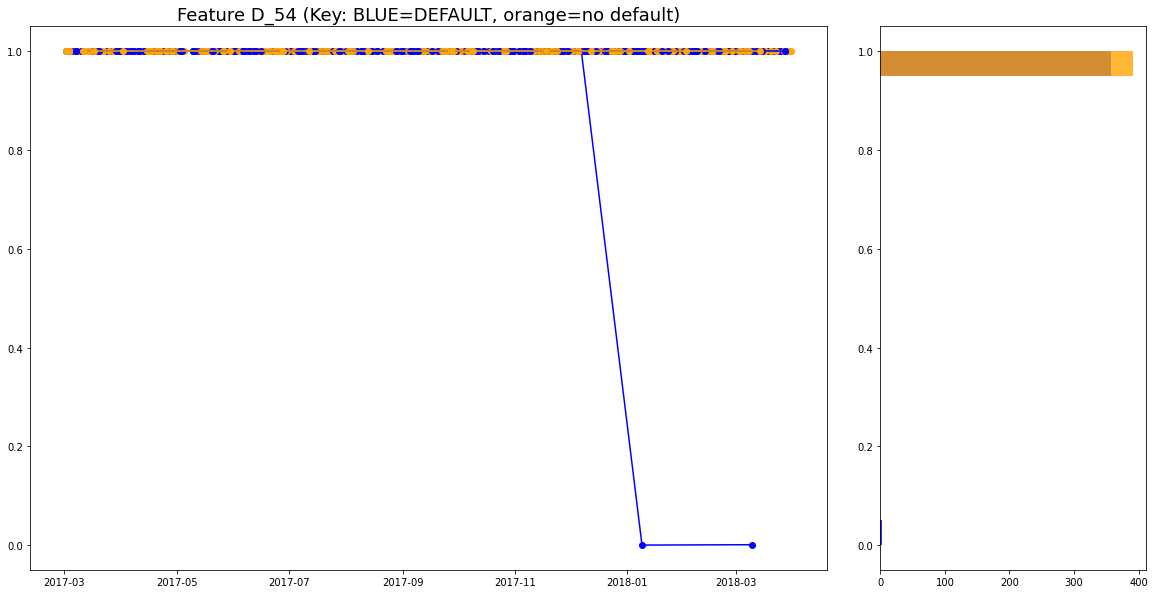

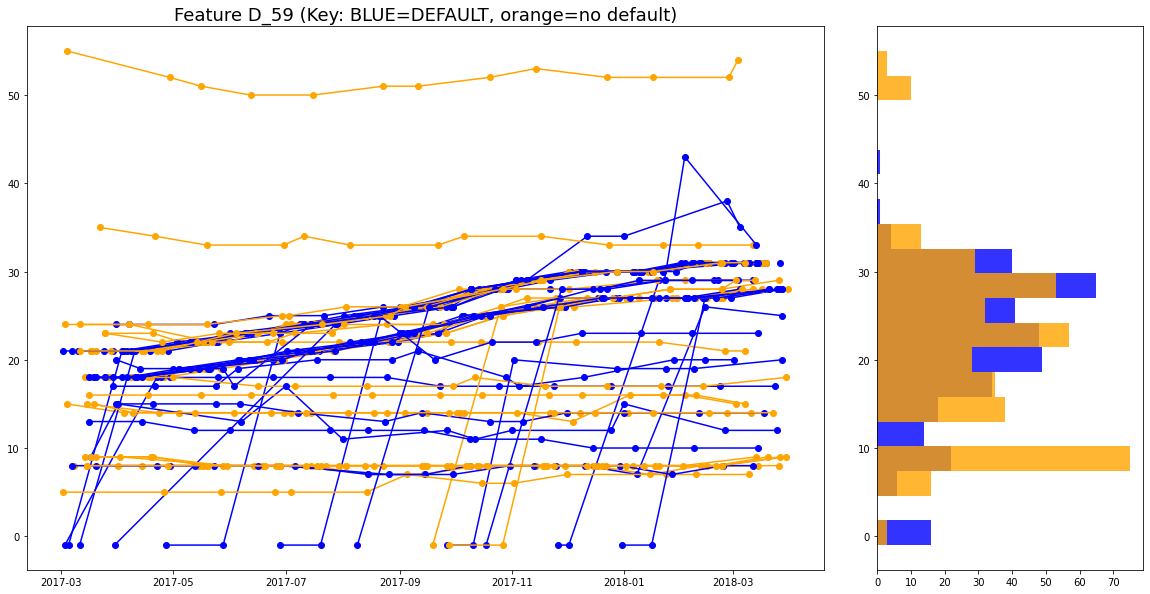

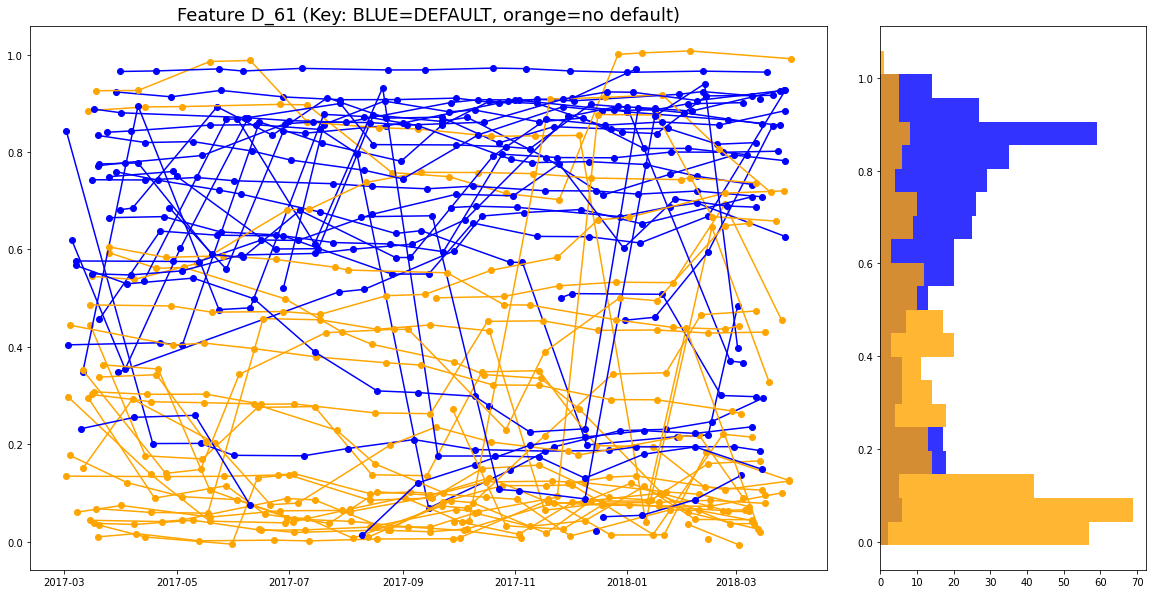

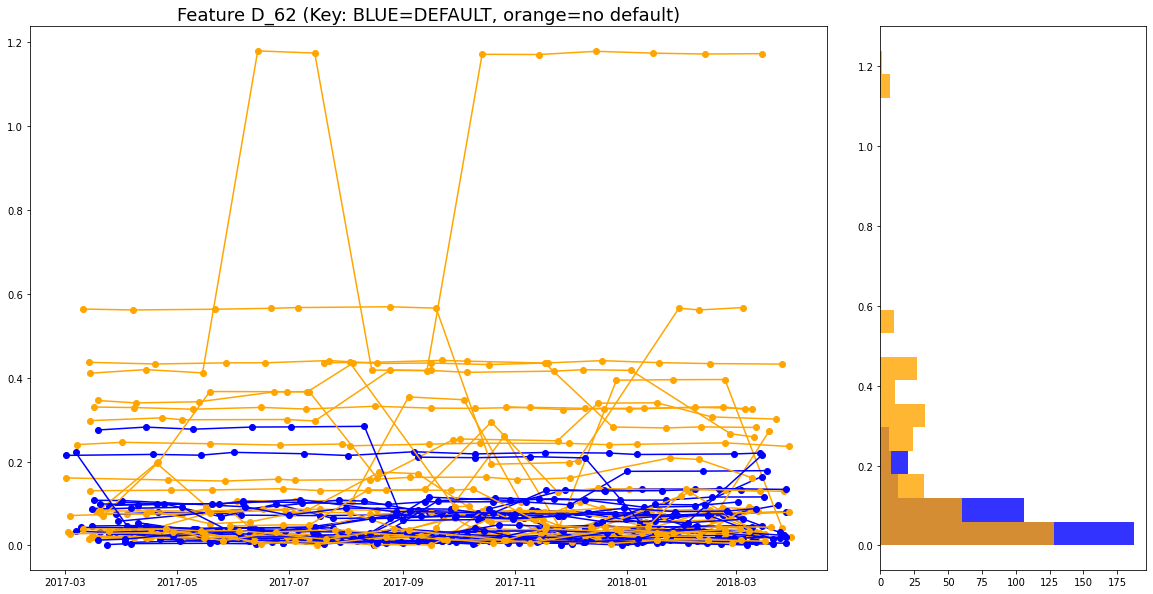

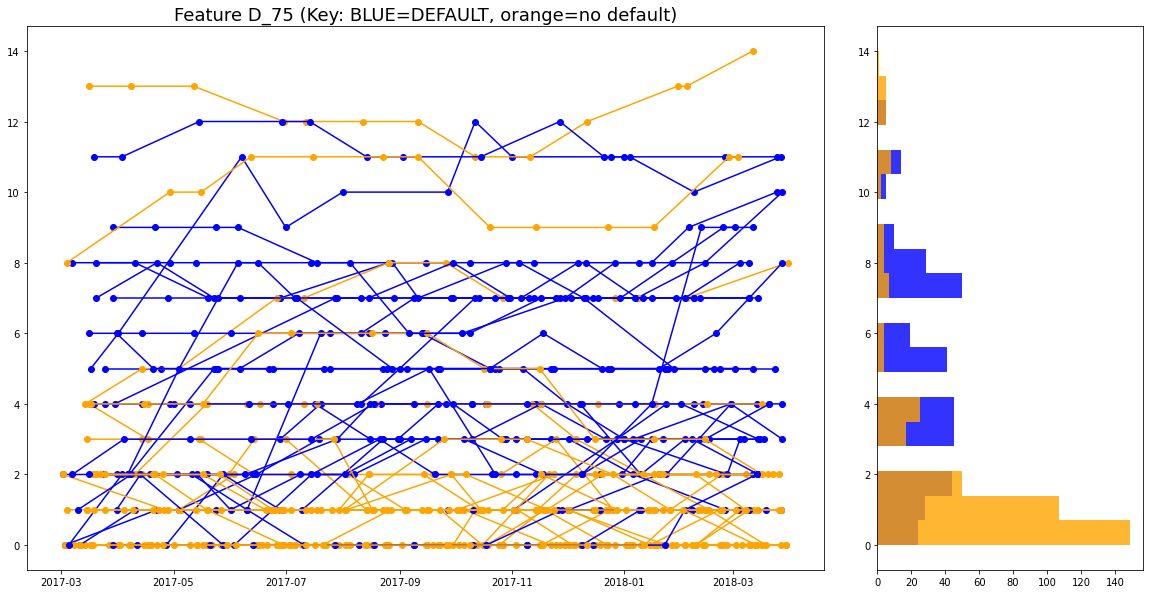

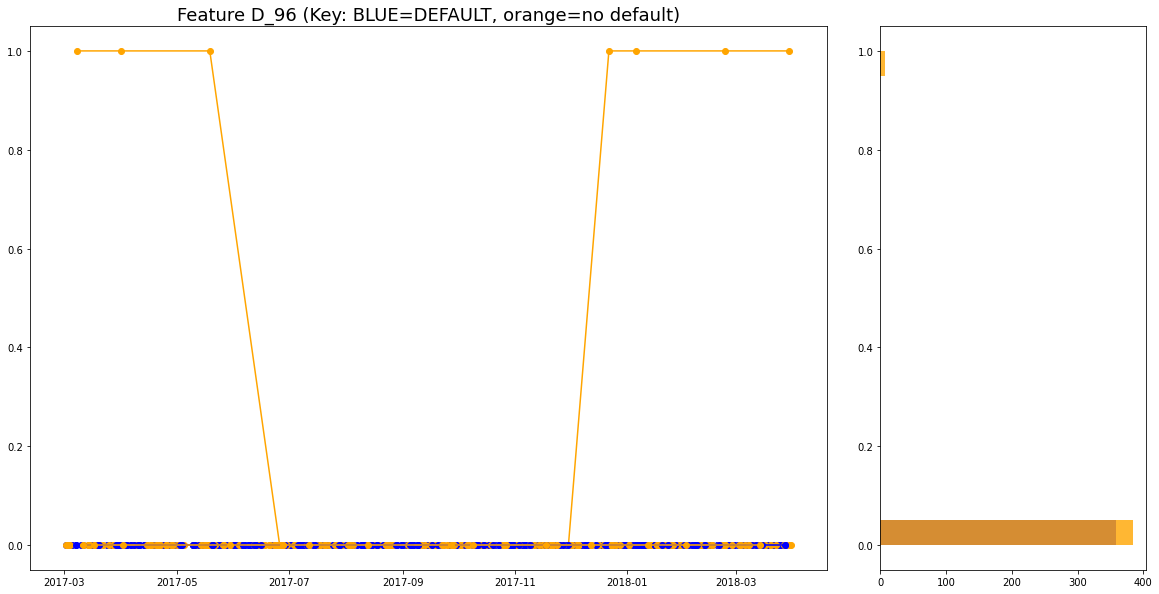

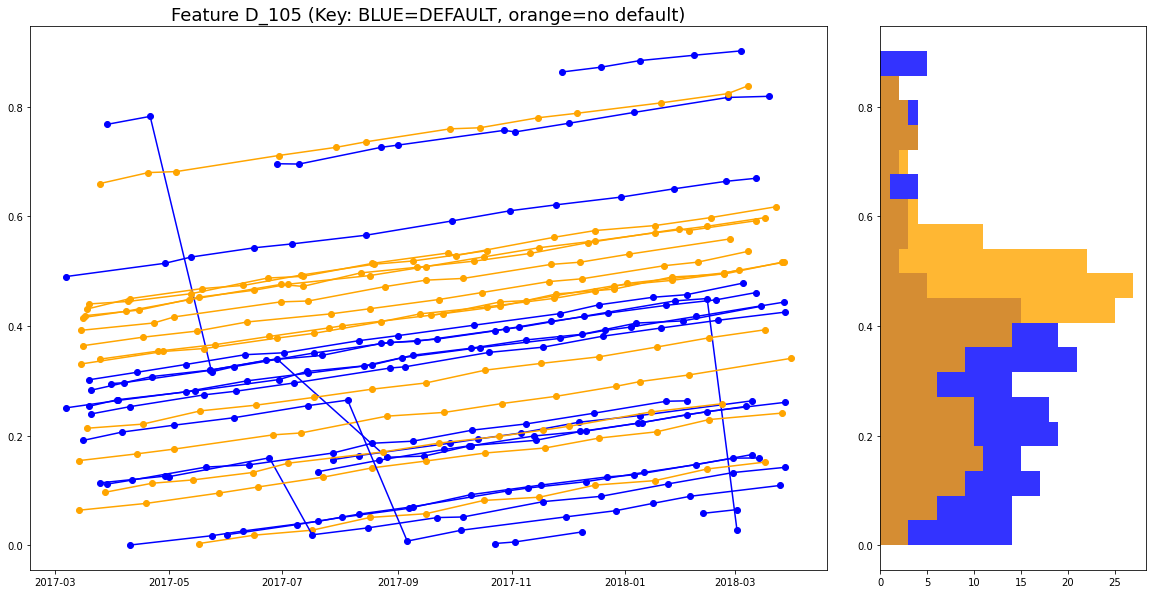

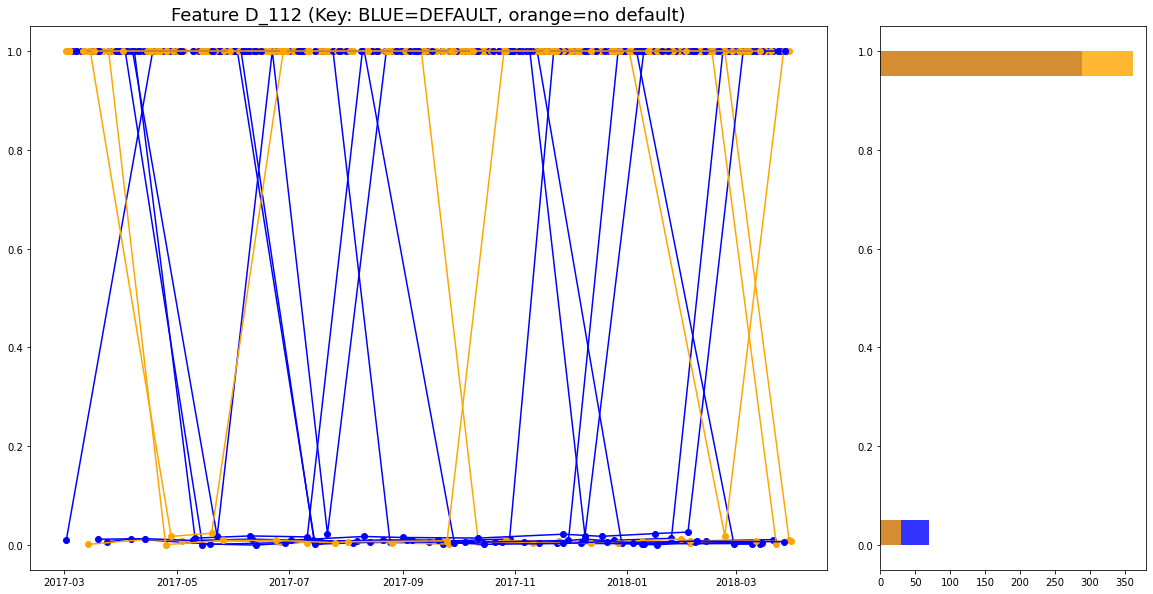

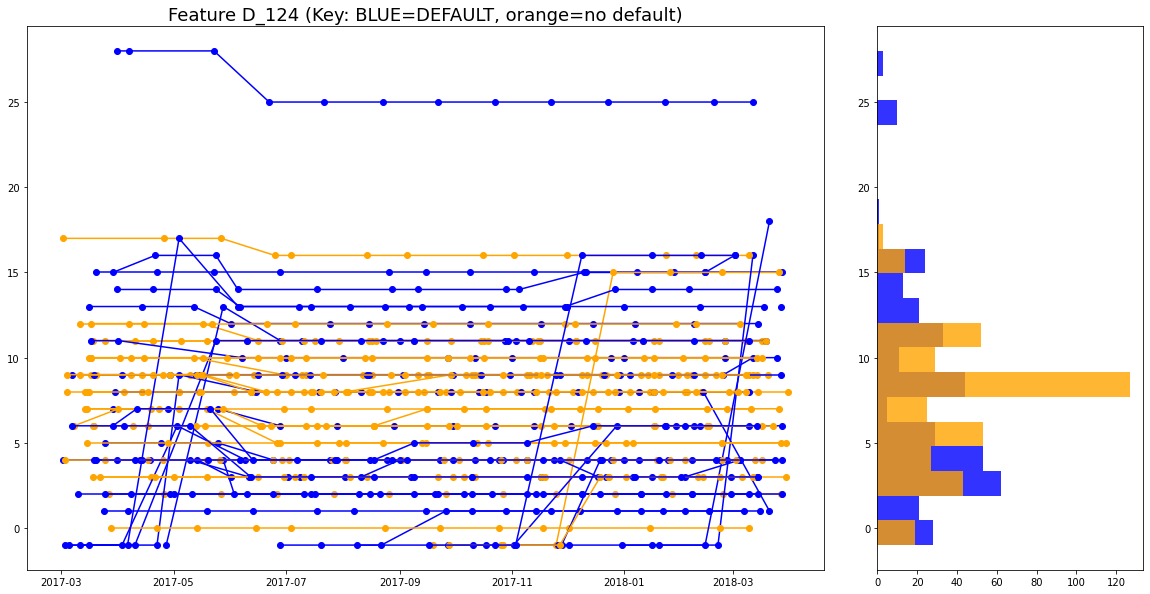

In [10]:
# LEAVE LIST BLANK TO PLOT ALL
plot_time_series('D',[39,41,47,45,46,48,54,59,61,62,75,96,105,112,124])

# Plot Spend Variables

#########################
Plotting 5 columns with prefix S
#########################


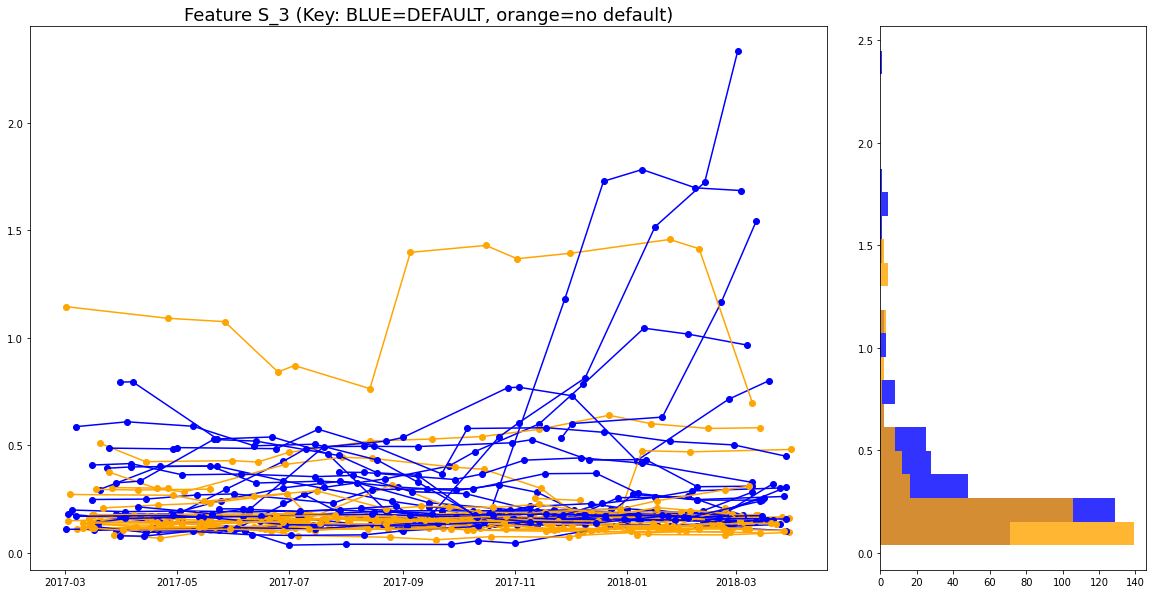

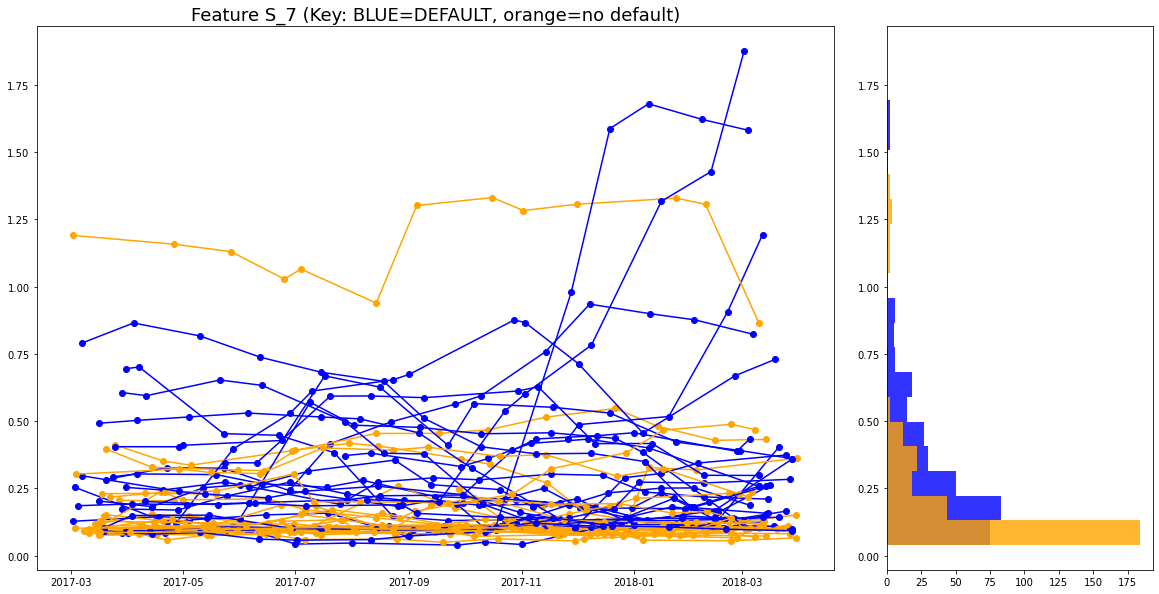

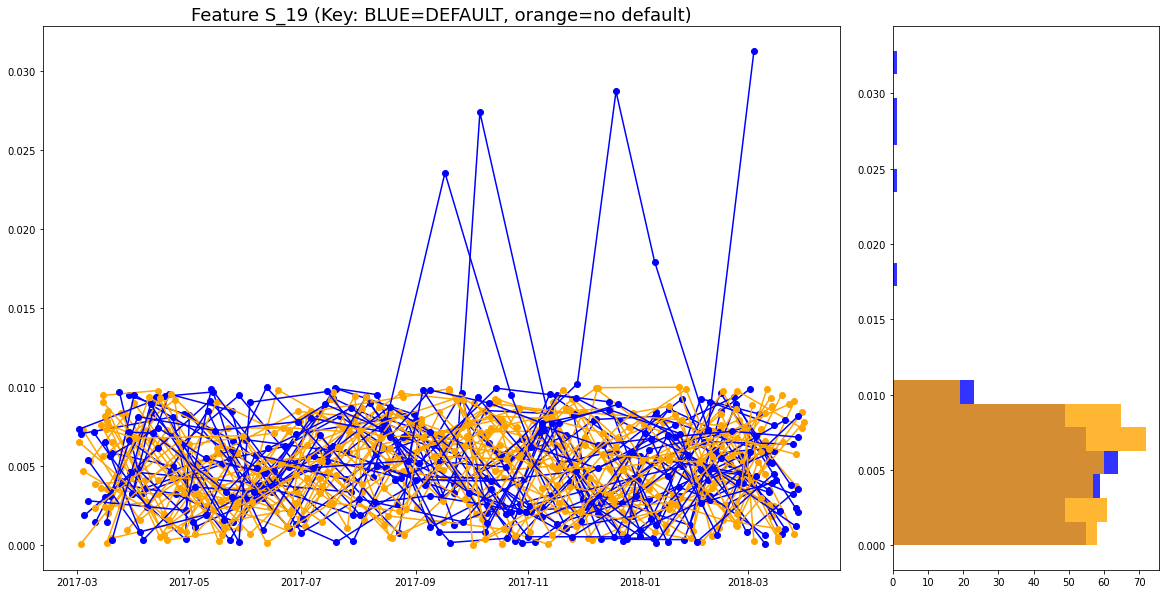

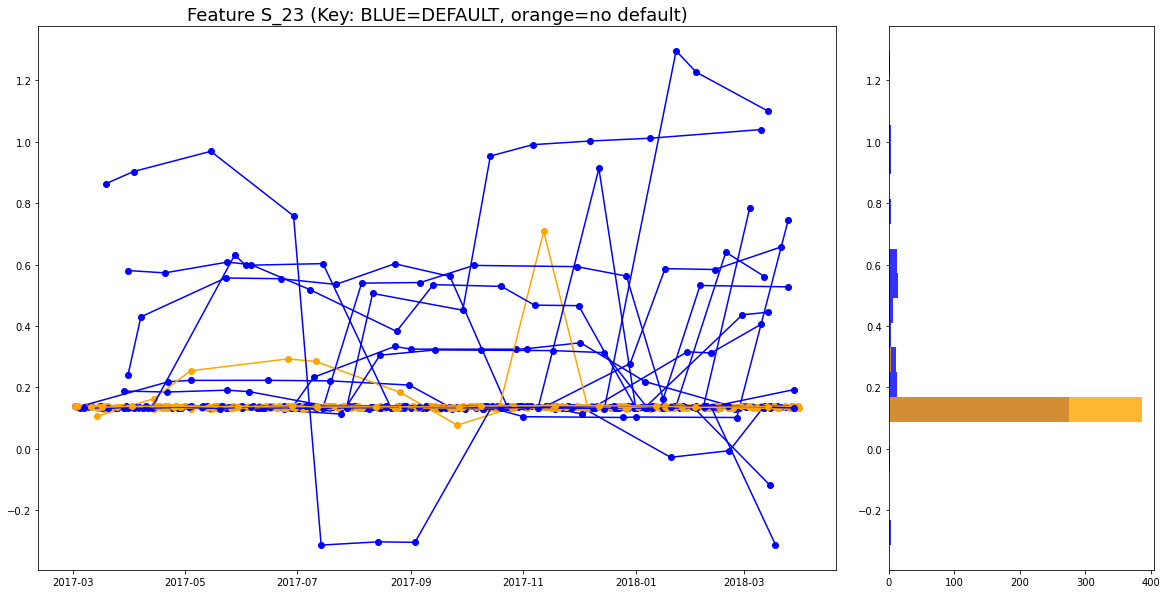

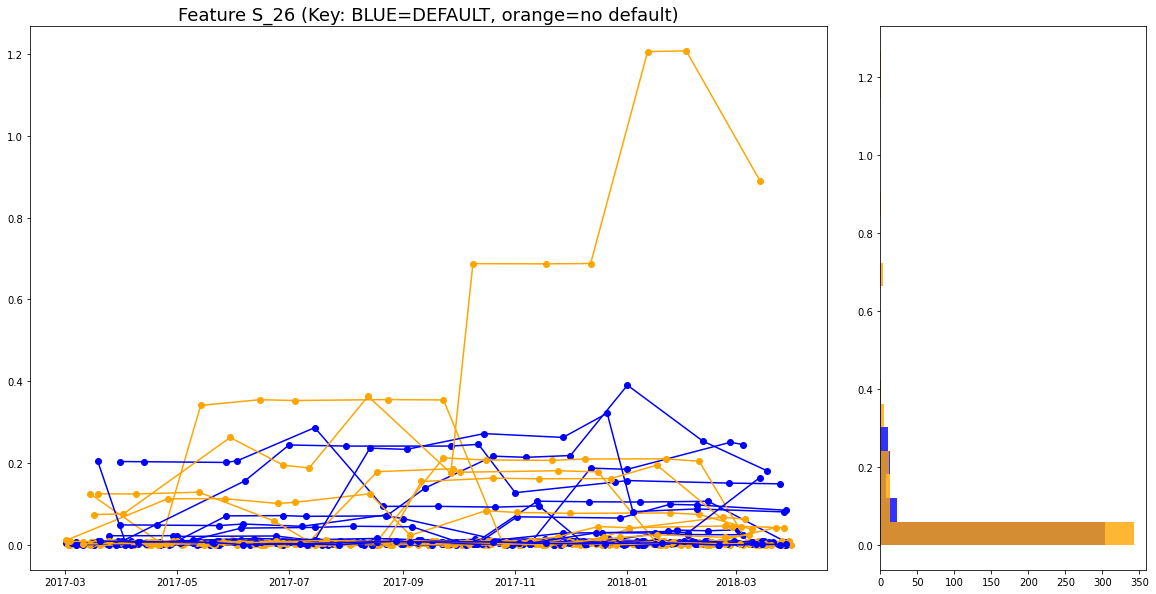

In [11]:
# LEAVE LIST BLANK TO PLOT ALL
plot_time_series('S',[3,7,19,23,26])

# Plot Payment Variables

#########################
Plotting 2 columns with prefix P
#########################


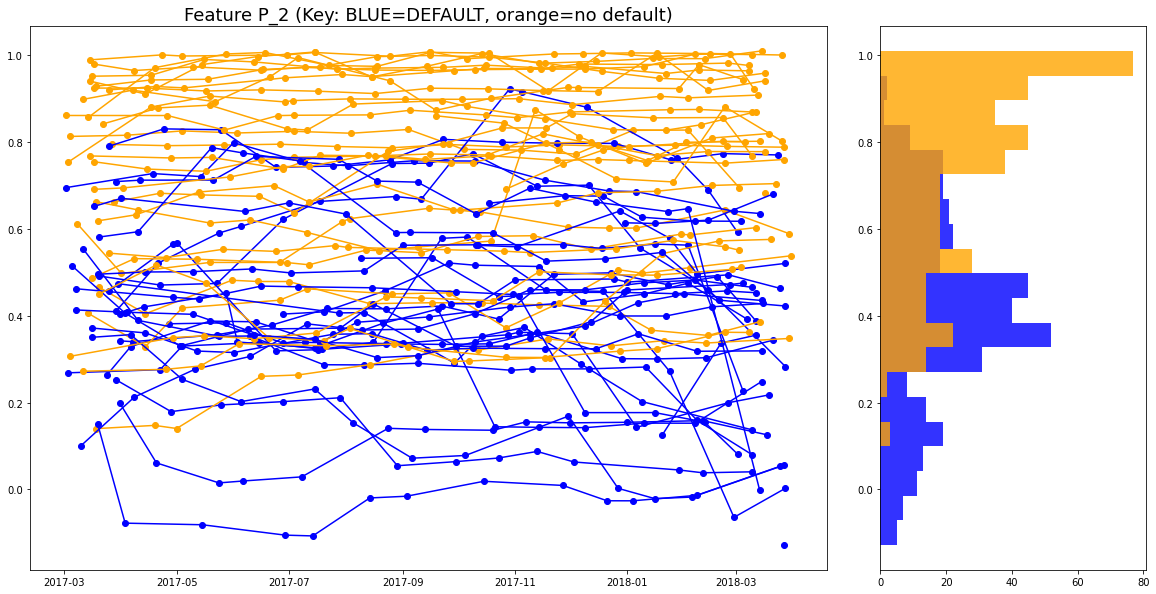

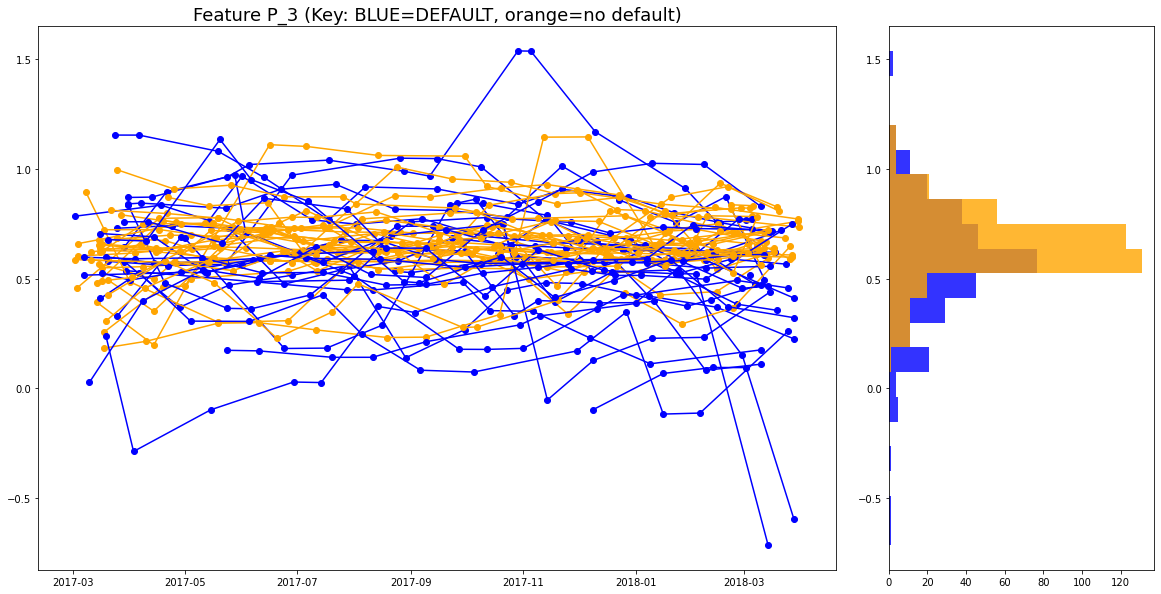

In [12]:
# LEAVE LIST BLANK TO PLOT ALL
plot_time_series('P',[2,3])

# Plot Balance Variables

#########################
Plotting 7 columns with prefix B
#########################


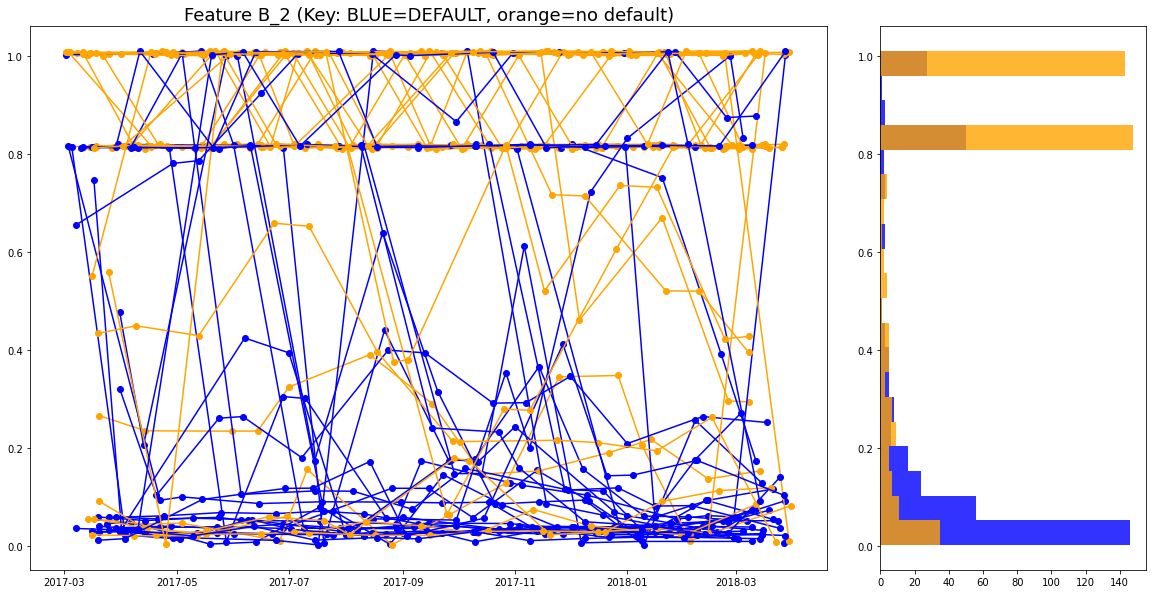

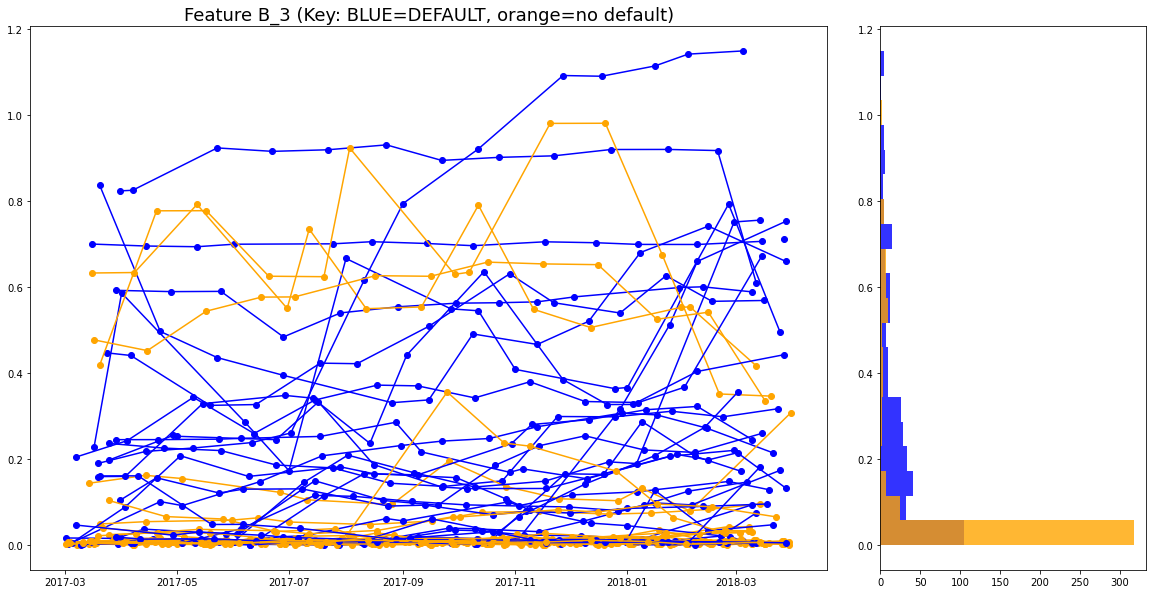

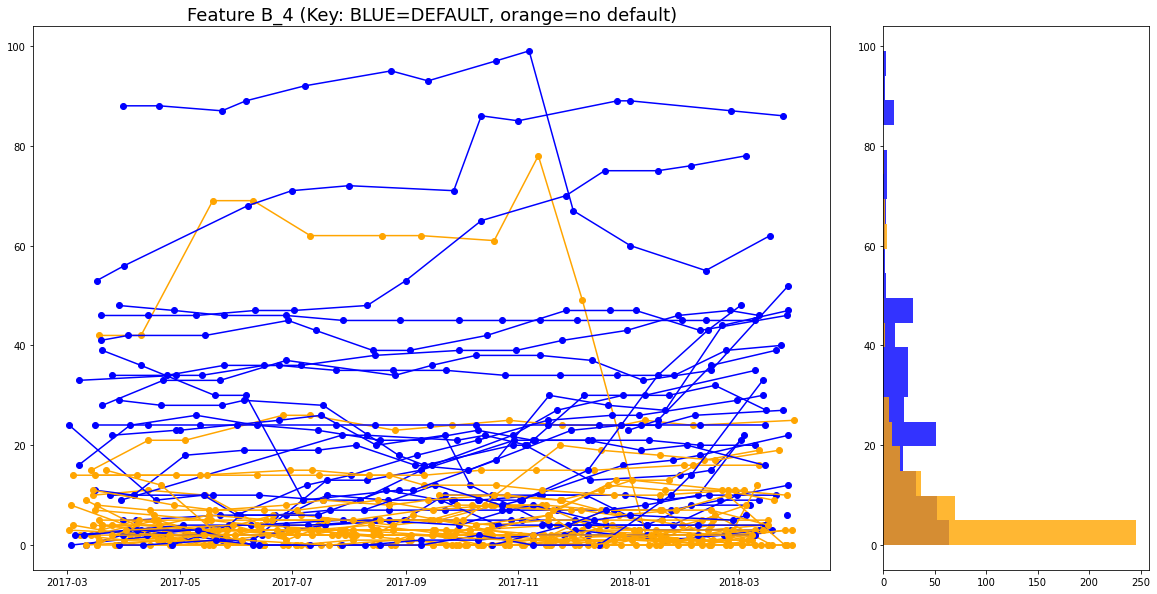

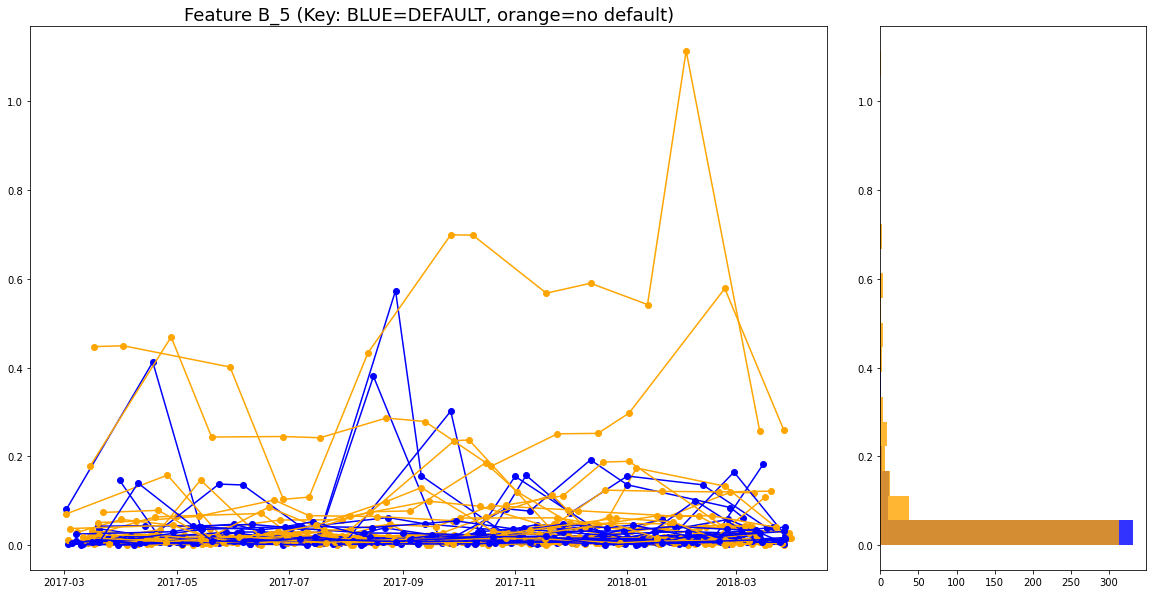

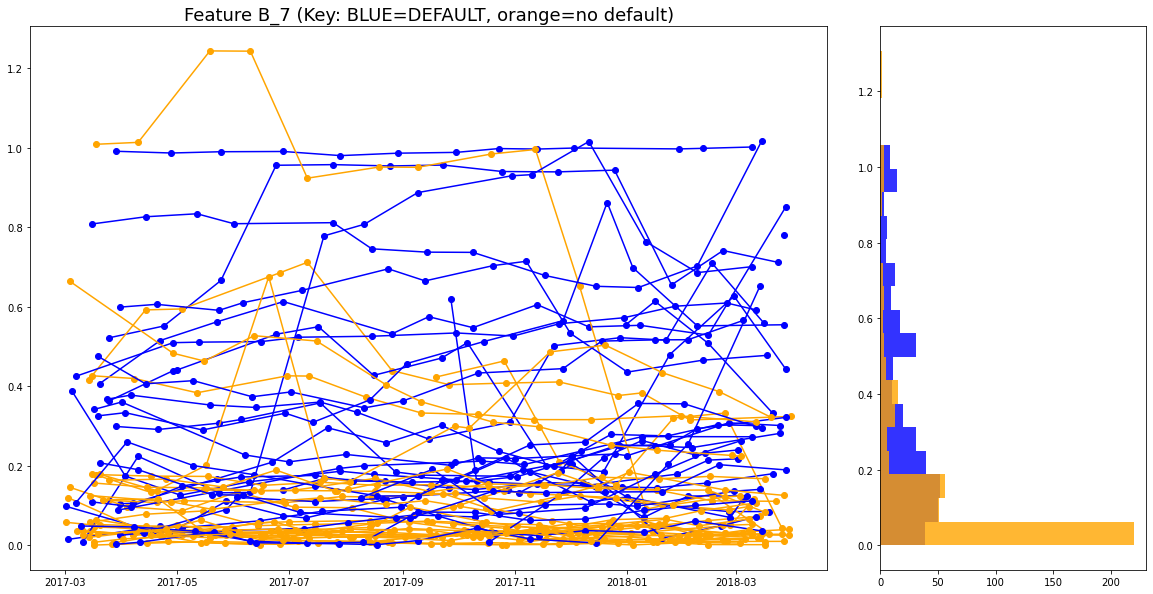

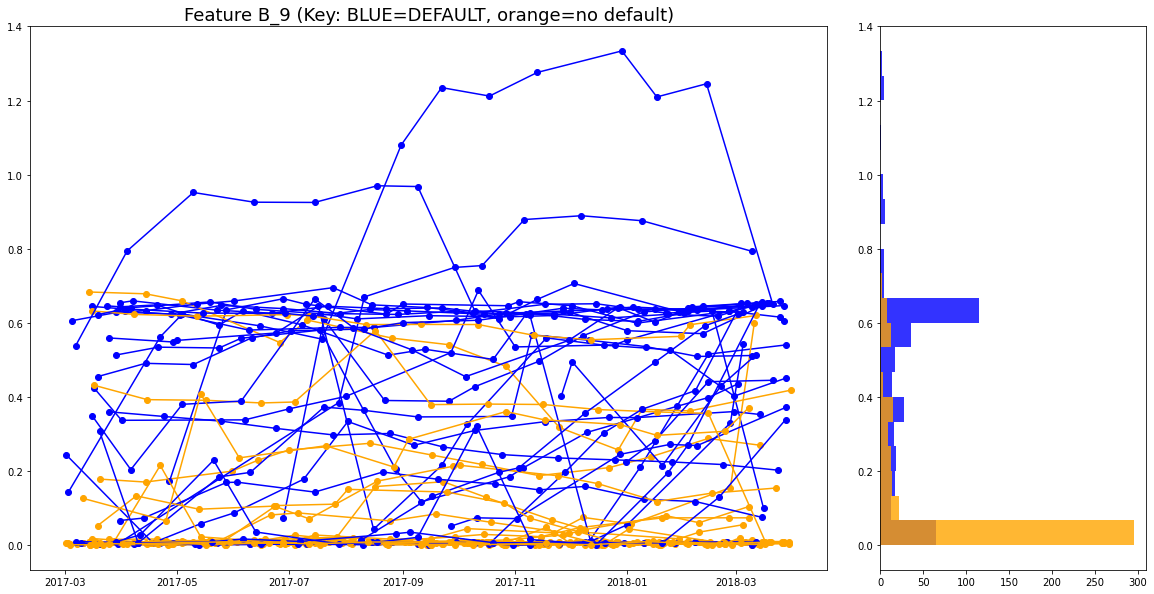

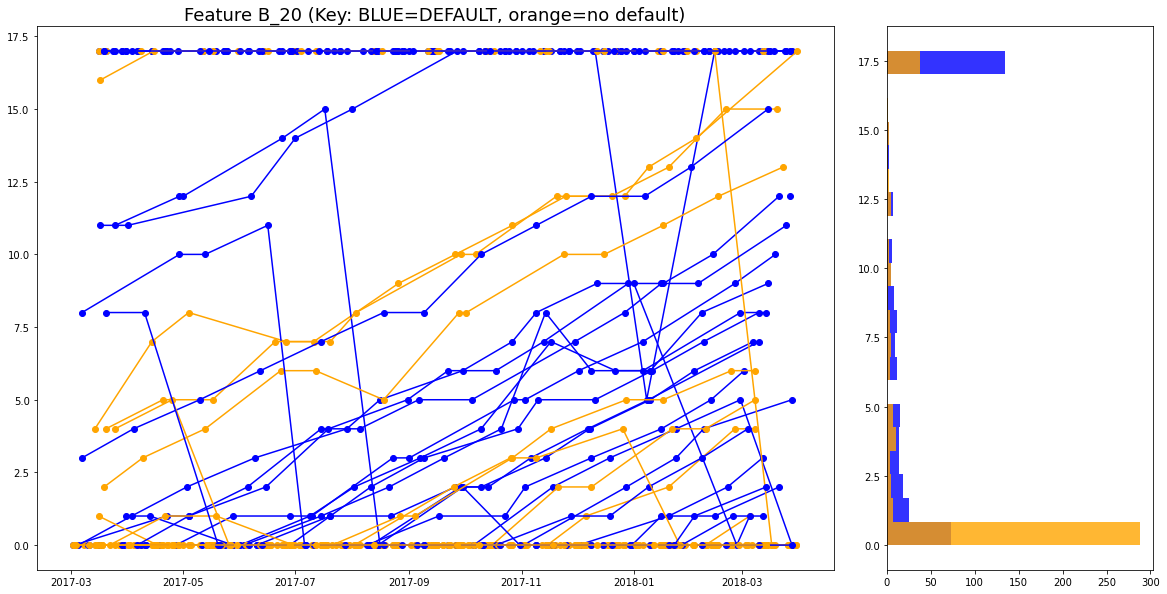

In [13]:
# LEAVE LIST BLANK TO PLOT ALL
plot_time_series('B',[2,3,4,5,7,9,20])

# Plot Risk Variables

#########################
Plotting 4 columns with prefix R
#########################


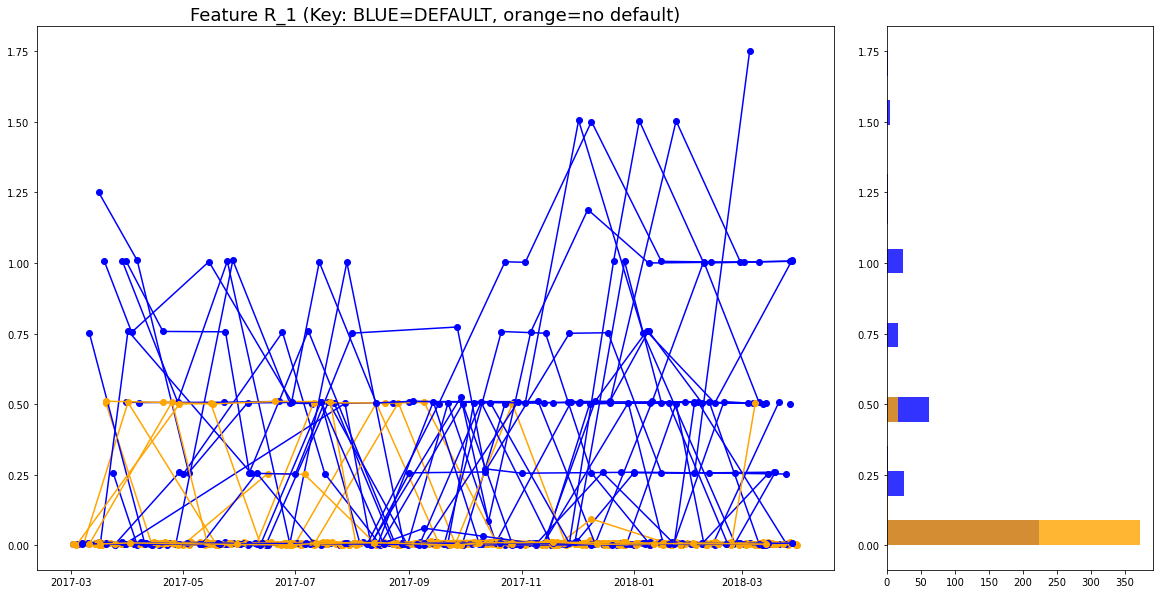

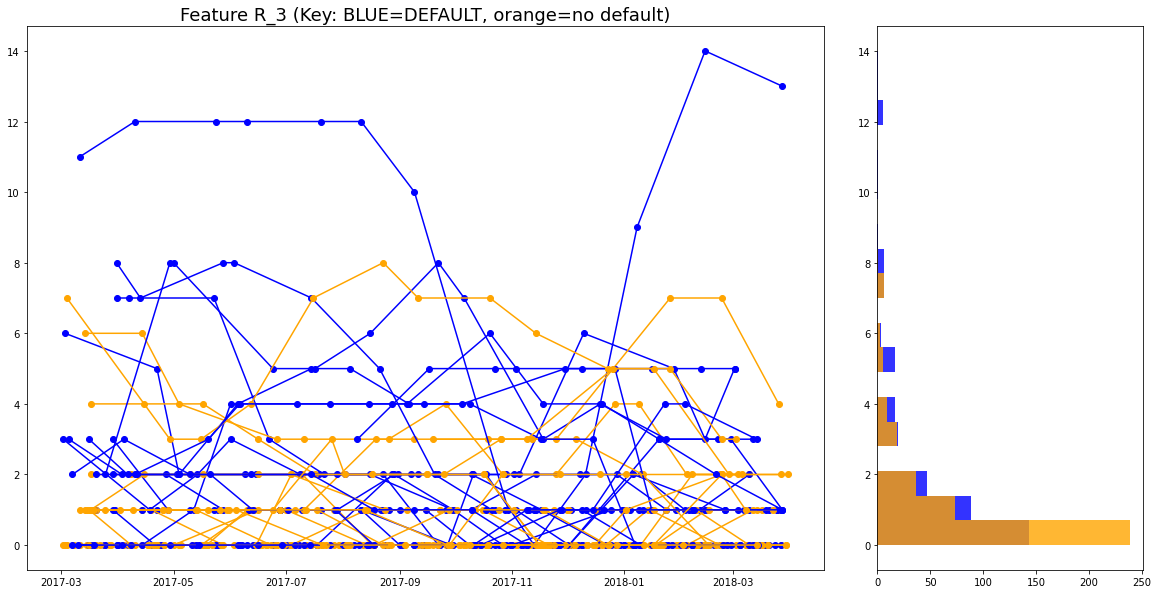

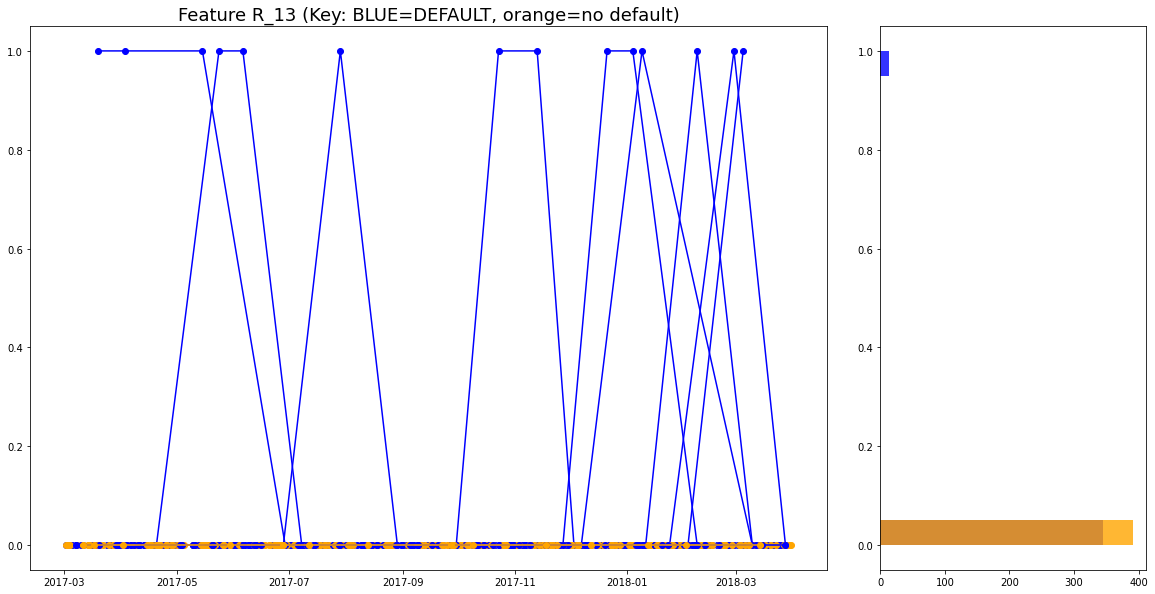

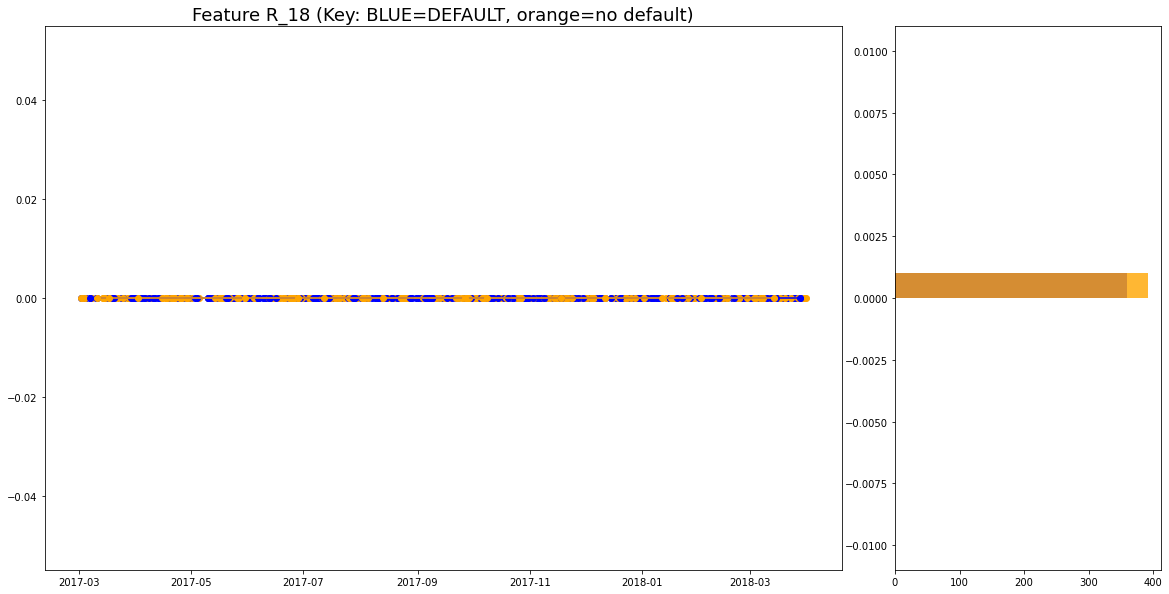

In [14]:
# LEAVE LIST BLANK TO PLOT ALL
plot_time_series('R',[1,3,13,18])